# Nonlinear Differential Equations: Carleman Linearization Block Encoding

<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2024 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

In [1]:
from pyLIQTR.circuits.operators                     import *
from pyLIQTR.BlockEncodings.CarlemanLinearization   import Carleman_Linearization
from pyLIQTR.ProblemInstances.NonlinearODE          import FOperators
from pyLIQTR.utils.circuit_decomposition            import circuit_decompose_multi
from pyLIQTR.utils.global_ancilla_manager           import gam
from pyLIQTR.utils.resource_analysis                import estimate_resources
from pyLIQTR.utils.printing                         import openqasm

from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran.cirq_interop.jupyter_tools import svg_circuit
from qualtran import Register, Signature, QAny

import matplotlib.pyplot as plt
from qualtran import *
import numpy as np
import cirq
import math

# Overview

This notebook details the block encoding technique developed by Parker Kuklinski and Benjamin Rempfer for Carleman Linearization. After reviewing its contents one should be able to generate the circuitry required to encode a Carleman matrix given some initial parameters. These techniques are under development and a manuscript is in preparation.

# Procedure 

Our goal is to take as input the block-encoded $F$ matrices that define a nonlinear equation 

$$\frac{du}{dt}=F_0+F_1u+F_2u^{\otimes 2}$$

and output a block-encoding for $A$ such that 

$$
    \frac{du}{dt}\begin{pmatrix} u \\ u^{\otimes 2} \\ u^{\otimes 3} \\ \vdots \\ u^{\otimes (K-1)} \\ u^{\otimes K}\end{pmatrix}=\begin{pmatrix} A^1_1 & A^1_2 & ~ & ~ & ~ & ~ \\ A^2_1 & A^2_2 & A^2_3 & ~ & ~ & ~ \\ ~ & A^3_2 & A^3_3 & A^3_4 & ~ & ~ \\ ~ & ~ & \ddots & \ddots & \ddots & ~ \\ ~ & ~ & ~ & A^{K-1}_{K-2} & A^{K-1}_{K-1} & A^{K-1}_K \\ ~ & ~ & ~ & ~ & A^K_{K-1} & A^K_K\end{pmatrix}\begin{pmatrix} u \\ u^{\otimes 2} \\ u^{\otimes 3} \\ \vdots \\ u^{\otimes (K-1)} \\ u^{\otimes K}\end{pmatrix}+\begin{pmatrix} F_0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ 0 \end{pmatrix}
$$

where

$$
    A ^{n+1}_n=\sum _{k=0}^{n-1}\left( I^{\otimes k}\otimes F_0\otimes I^{\otimes (n-k-1)}\right)
$$
$$
    A ^n_n=\sum _{k=0}^{n-1}\left( I^{\otimes k}\otimes F_1\otimes I^{\otimes (n-k-1)}\right)
$$
$$
    A ^n_{n+1}=\sum _{k=0}^{n-1}\left( I^{\otimes k}\otimes F_2\otimes I^{\otimes (n-k-1)}\right)
$$

In order to efficiently encode the Carleman matrix we relabel it. Each $A_{n\pm1}^n$ is a sum of $n$ matrices. So a simple sum of all block-encoded terms would yield quadratically more resources than our relabelling scheme. Details in manuscript.

In [2]:
n = 2
K = 4

a0_in = n
a1 = n
a2_in = math.ceil(n/2)
a2_out = math.ceil(n)

alpha0 = 1
alpha1 = 1
alpha2 = 1

As we do not have explicit circuits for the $F$ matrices we will need a few parameters in their place. We define them above.

- $n$ : $F_1\in\mathcal{M}_{2^n\times2^n}(\mathbb{C})$
- $K$ : Number of Carleman truncation steps
- $a_{0i}$, $a_1$, $a_{2i}$, $a_{2o}$ : Number of ancilla needed for $F$ block-encodings
- $\alpha_0$, $\alpha_1$, $\alpha_2$ : Scaling factors of $F$ block-encodings

In [3]:
ancilla_register = Register("ancilla", QAny(bitsize = 7 + max(a0_in, a1, a2_in, a2_out) + math.ceil(np.log2(K))))
data_register = Register("data", QAny(bitsize = n*K+1))

signature = Signature([ancilla_register, data_register])
registers = get_named_qubits(signature)

The Carleman block-encoding acts on a data register of size $nK+1$ as the actual $A$ matrix is not a power of two size. This comes into play later when we must zero-out the basis states with junk data. The ancilla register defined above consists of persistent ancilla which must be initialized and cannot be used for more than one operator because they are used for matrix multiplication. The only other type of ancilla used in this circuit is a 'clean' qubit. These qubits are managed by a global manager which dynamically allocates and frees qubits as needed.

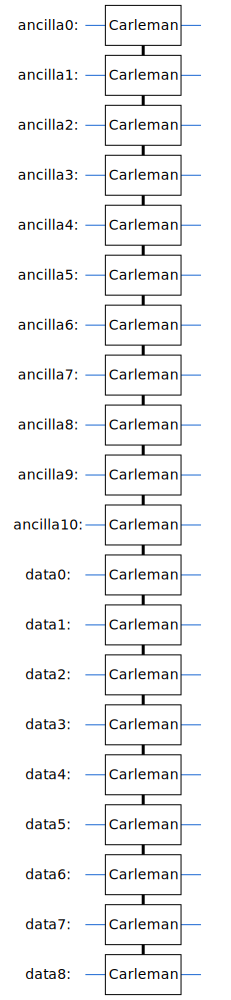

In [4]:
carlemanLinearization = Carleman_Linearization(FOperators(n, K, (a0_in, a1, a2_in, a2_out), (alpha0, alpha1, alpha2)), K)
circuit = cirq.Circuit(carlemanLinearization.on_registers(**registers))

svg_circuit(circuit, include_costs=False)

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `qualtran` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

We can decompose once to see what makes up the Carleman circuit at a high-level.

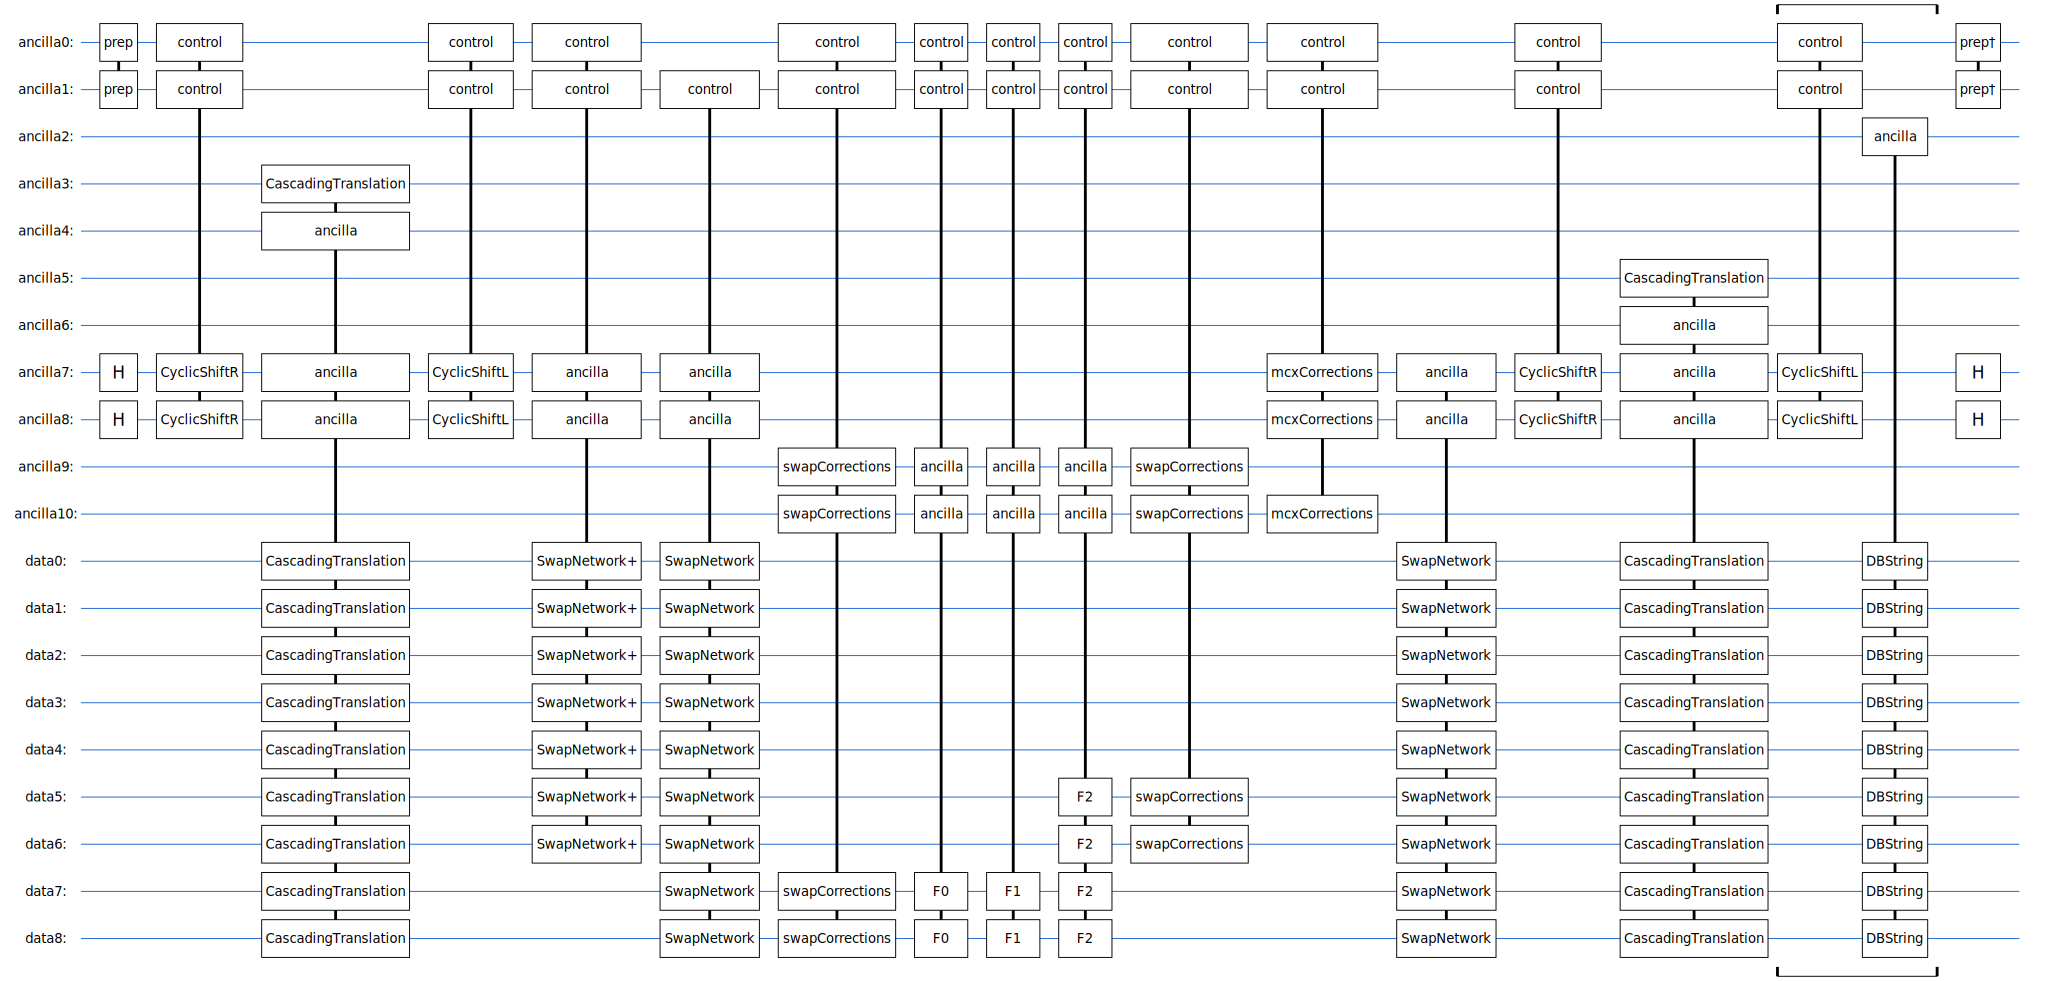

In [5]:
svg_circuit(circuit_decompose_multi(circuit, 1), include_costs=False)

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision. This can be passed explicitly using the `rotation_gate_precision` (default 1e-10) keyword argument, or can be implicitly calculated by passing the `circuit_precision`. If no precision argument is provided, the default value will be used.

WARNING: The qubit count does not account for dynamically allocated ancilla qubits. For the Carleman circuits this means that we are undercounting by a factor of at most two. 

In [6]:
estimate_resources(circuit)

{'LogicalQubits': 20, 'T': 356, 'Clifford': 1079}

---
#### LIQTR Like 👍 : Circuit Scheduling
---

Circuits can be 'scheduled' using the `pyLIQTR.scheduler.scheduler.schedule_circuit` function. This will provide circuit runtime, realistic qubit counts, T-depth, and more!

`schedule_circuit` takes a number of optional arguments depending on desired outputs. They are:
* `architecture_config`: a dictionary specifying timing for various gate types and restrictions on how many T gates can operate simultaneously. This dictionary must be formatted as follows:
    * `{'Execution Times': {('Gate 1',): Time X, ('Gate 2', 'Gate 3'): Time Y}, 'Max T': Z # of simultaneous T-gates allowed}`

* `full_profile`: default `False`. If set to `True`, function output will include individual gate counts, T-widths, and parallelism distribution data. (NOTE: T-widths and parallelism data will only be available if `decomp_level` is set to `'Full'`.)

* `decomp_level`: int, default 0. Levels of decomposition implemented before scheduling. If set to `0`, each operator will be decomposed to one/two-qubit gates only on its first occurance and cached for each future occurance. If set to `'Full'`, entire circuit will be decomposed to one/two-qubit gates before scheduling. 

* `context` : cirq.DecompositionContext, default is none which will result in the use of a context manager that tries to minimize the number of ancilla generated. At times, certain Qualtran Bloqs may have an error in their decomposition which results in ancilla not being properly cleared. If this happens, we recommend passing `context=cirq.DecompositionContext(cirq.SimpleQubitManager())` to resolve this issue, at the cost of an overzealous qubit allocation.

* `circuit_precision`: default 1e-3. Rotations are decomposed to a given precision. This can be passed explicitly using the `circuit_precision` keyword argument. If no precision argument is provided, the default value will be used. Note that higher-precision will generally increase the resource cost.

For further details on scheduler capabilities, see `Algorithms_and_Infrastructure/scheduling_example.ipynb`.

In [7]:
from pyLIQTR.scheduler.scheduler import schedule_circuit
res = schedule_circuit(circuit, full_profile=True, decomp_level='Full')
for r in res:
    print(f"{r} : {res[r]}")

Decomposition levels to basic gates: 7.
Time to schedule: 0.2783454000018537 s.
Total time for execution : 879
Circuit T-depth : 192
Number of qubits used : 28
Gate profile : {'T': 292, 'H': 223, 'S': 73, 'CX': 564, 'CZ': 73, 'Pauli (X, Y, Z)': 44, 'Rotation': 4}
Active qubit distribution : {11: 2, 8: 7, 5: 58, 7: 24, 2: 111, 4: 116, 3: 171, 1: 137, 6: 34, 10: 1, 9: 2}
T-widths : {0: 472, 8: 1, 5: 1, 3: 27, 1: 128, 2: 35}


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [7]:
context = cirq.DecompositionContext(gam)
for idx,line in enumerate(openqasm(circuit,rotation_allowed=True,context=context)):
    if idx < 100:
        print(line)

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [gancilla_c(0), gancilla_c(1), gancilla_c(2), gancilla_c(3), gancilla_c(4), gancilla_c(5), gancilla_c(6), gancilla_c(7), ancilla0, ancilla1, ancilla2, ancilla4, ancilla6, ancilla7, ancilla8, ancilla9, ancilla10, data0, data1, data2, data3, data4, data5, data6, data7, data8]
qreg q[26];


ry(pi*0.5) q[8];
ry(pi*0.5) q[9];
h q[13];
h q[14];
ccx q[8],q[9],q[14];
ccx q[8],q[9],q[13];
x q[13];
x q[14];
h q[0];
t q[0];
cx q[13],q[0];
cx q[14],q[0];
cx q[0],q[13];
cx q[0],q[14];
tdg q[13];
tdg q[14];
t q[0];
cx q[0],q[13];
cx q[0],q[14];
h q[0];
s q[0];
x q[14];
cx q[0],q[11];
cx q[13],q[0];
cx q[0],q[11];
cx q[11],q[24];
h q[2];
t q[2];
cx q[11],q[2];
cx q[24],q[2];
cx q[2],q[11];
cx q[2],q[24];
tdg q[11];
tdg q[24];
t q[2];
cx q[2],q[11];
cx q[2],q[24];
h q[2];
s q[2];
cx q[2],q[23];
h q[6];
t q[6];
cx q[2],q[6];
cx q[23],q[6];
cx q[6],q[2];
cx q[6],q[23];
tdg q[2];
tdg q[23];
t q[6];
cx q[6],q[

---

In [8]:
def bar_plot(ax, data, error_data, colors=None, total_width=4/5, single_width=1, legend=True):

    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_bars = len(data)
    bar_width = total_width / n_bars

    bars = []
    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = plt.bar(x + x_offset + 3, y, width=bar_width * single_width, yerr = error_data[i][x], color=colors[i % len(colors)])
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys(), fontsize=9)

The asympotic T scaling for the Carleman circuit is $\mathcal{O}(nK^2)$. Let's generate some statistics to verify this.

In [9]:
data_dict = {}
for n in range(10,60,10):
    data_dict[n] = []
    for K in range(3,12,1):

        a0_in = n
        a1 = n
        a2_in = math.ceil(n/2)
        a2_out = math.ceil(n)

        ancilla_register = Register("ancilla", QAny(bitsize = 7 + max(a0_in, a1, a2_in, a2_out) + math.ceil(np.log2(K))))
        data_register = Register("data", QAny(bitsize = n * K + 1))

        signature = Signature([ancilla_register, data_register])
        registers = get_named_qubits(signature)

        carlemanLinearization = Carleman_Linearization(FOperators(n, K, (a0_in, a1, a2_in, a2_out), (alpha0, alpha1, alpha2)), K)
        circuit = cirq.Circuit(carlemanLinearization.on_registers(**registers))

        data_dict[n].append(estimate_resources(circuit)["T"])

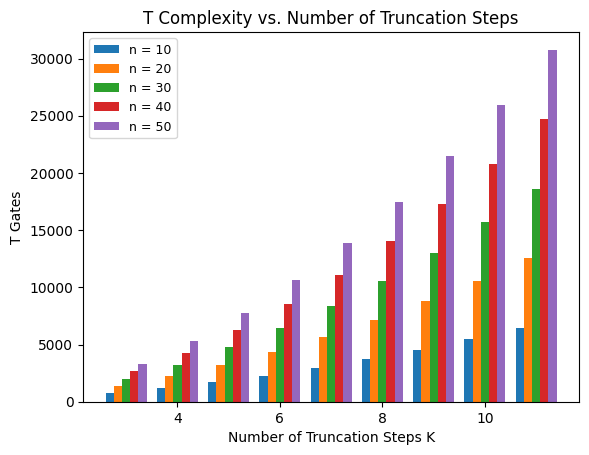

In [10]:
data = {
    "n = 10" : data_dict[10],
    "n = 20" : data_dict[20],
    "n = 30" : data_dict[30],
    "n = 40" : data_dict[40], 
    "n = 50" : data_dict[50]
}

error_data = [[0,]*10]*5

fig, ax = plt.subplots()
bar_plot(ax, data, error_data)

plt.xlabel("Number of Truncation Steps K")
plt.ylabel("T Gates")
plt.title("T Complexity vs. Number of Truncation Steps")
plt.show()